# COVID FAKE NEWS DETECTION 

Importing necessary libraries:

In [85]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf 
from tensorflow import keras

%matplotlib inline

In [3]:
link = ''

cnews = pd.read_csv(link, sep=',')

cnews.head()

,title,text,source,label
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,Fake
1,NaN,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,Fake
2,NaN,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,Fake
3,NaN,The Corona virus is a man made virus created i...,JoanneWrightForCongress,Fake
4,NaN,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,Fake


In [5]:
cnews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1164 entries, 0 to 1163
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   1082 non-null   object
 1   text    1154 non-null   object
 2   source  1144 non-null   object
 3   label   1159 non-null   object
dtypes: object(4)
memory usage: 36.5+ KB


In [6]:
cnews.shape 

(1164, 4)

The dataset contains 1164 news about COVID virus that are taged as true or fake. The columns of teh dataset are the title of the news, the text, the source (which can be both a newspaper, a politician, website, etc) and the label, which is the target variable ('FAKE', 'TRUE'). First of all we are going to check if the labels are balanced and are only 'TRUE' or 'FALSE'.

In [7]:
cnews.label.value_counts()

TRUE    584
Fake    345
fake    230
Name: label, dtype: int64

Text(0, 0.5, 'Count')

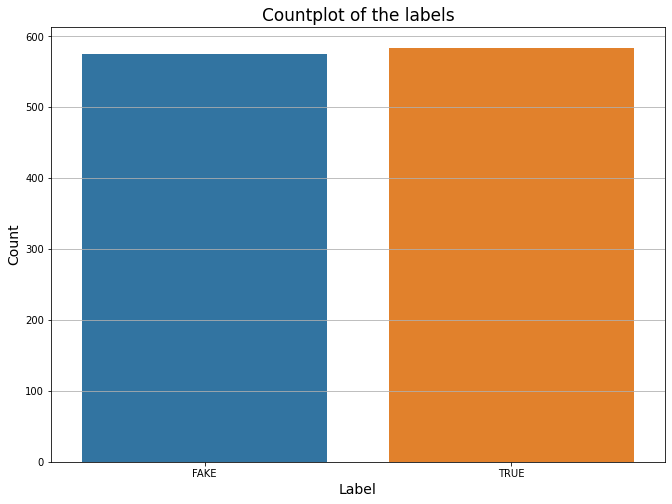

In [8]:
cnews['label'] = cnews.label.apply(lambda x: 'FAKE' if x == 'fake' else x)
cnews['label'] = cnews.label.apply(lambda x: 'FAKE' if x == 'Fake' else x)

from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
sns.countplot(cnews.label)
plt.grid(axis='y')
plt.title('Countplot of the labels', fontsize=17)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)

As we can see in the graph above the labels are clearly balanced. Now let's going to check the source column:

In [9]:
cnews.source.sort_values().unique() # In order to identify better the values that differs very vaguely but essentially are the same source (Facebook --> facebook for example) we are going to sort them alphabetically.

array([' AB-TC', '/cordis.europa.eu',
       'Change Your Thoughts Change Your Life', 'CharlieKirk',
       'Denis chernomazov', 'Dr. A. Sosnowski', 'Evrozona', 'Facebook',
       'HealingOracle.ch', 'Instagram',
       'Japanese doctors treating COVID-19 cases',
       'JoanneWrightForCongress', 'Lijian Zhao', 'Manik',
       'Ministry of Health', 'NTV', 'NWLLAB', 'Olga',
       'Peter Lee Goodchild', 'RudyGiuliani', 'Sputnik Czech',
       'Taiwan Experts', 'Tatyana', 'Tin woodman',
       'To Vaccinate Or Not To Vaccinate', 'YouTube', 'Youtube',
       'canada.ca', 'cdc.gov', 'coronavirusmedicalkit.com', 'facebook',
       'fort-russ.com', 'gurunanda.com', 'herbalamy.com',
       'http://4chan.org', 'http://8ch.net', 'http://MyNaCl.blogspot.in',
       'http://archive.is/', 'http://archive.md/', 'http://archive.vn/',
       'http://geoclub.info/', 'http://now8news.com/',
       'http://oneworld.press/', 'http://orthomolecular.org/',
       'http://redstatewatcher.com/',
       'http

After a while looking for equivalent labels, this are which I have found:

Facebook -- facebook

Youtube -- YouTube -- https://www.youtube.com/

https://www.who.int/emergencies/diseases/novel-coronavirus-2019/advice-for-public -- https://www.who.int/emergencies/diseases/novel-coronavirus-2019/advice-for-public/myth-busters

https://www.washingtonpost.com/ -- https://www.washingtonpost.com/opinions

https://www.who.int/ -- https://www.who.int/emergencies/diseases/novel-coronavirus-2019/advice-for-public -- https://www.who.int/emergencies/diseases/novel-coronavirus-2019/advice-for-public/myth-busters

https://www.snopes.com/ -- https://www.snopes.com/news/2020/03/03/why-hand-washing-really-is-as-important-as-doctors-say/?collection-id=241238

http://archive.is/ -- http://archive.md/ -- http://archive.vn/

https://jimhumble.co -- https://jimhumble.co/

http://www.Instagram.com -- Instagram

https://www.sciencedaily.com/ -- https://www.sciencedaily.com/releases/2020/03/200317175442.htm

https://www.newstarget.com -- https://www.newstarget.com/

https://www.globalresearch.ca' --  'https://www.globalresearch.ca/'

https://www.naturalnews.com -- https://www.naturalnews.com/

https://web.archive.org -- https://web.archive.org/

https://www.ecdc.europa.eu -- https://www.ecdc.europa.eu/

In order to get more precission when we train the algoritm or perform metrics, we are going to change some of the labels from above joining in one two or more that are the same but but they are written differently:

In [10]:
cnews.source = cnews.source.apply(lambda x: 'YouTube' if x == 'Youtube' else x)

cnews = cnews.replace(['https://www.youtube.com/', 'facebook', 'https://www.snopes.com/news/2020/03/03/why-hand-washing-really-is-as-important-as-doctors-say/?collection-id=241238', 'https://jimhumble.co', 'http://www.Instagram.com', 'https://www.sciencedaily.com/', 'https://www.newstarget.com/', 'https://www.globalresearch.ca', 'https://www.naturalnews.com', 'https://web.archive.org', 'https://www.ecdc.europa.eu'],['YouTube', 'Facebook', 'https://www.snopes.com/', 'https://jimhumble.co/', 'Instagram', 'https://www.sciencedaily.com/releases/2020/03/200317175442.htm', 'https://www.newstarget.com', 'https://www.globalresearch.ca/', 'https://www.naturalnews.com/', 'https://web.archive.org/', 'https://www.ecdc.europa.eu/']) 

In [12]:
cnews.label.unique() # Looking to the values of the labels column, we see that there is Nan values.in

array(['FAKE', nan, 'TRUE'], dtype=object)

Now we are going to fill or drop the Nan values of the features and the labels:

In [13]:
cnews['title'] = cnews.title.fillna('Missing')
cnews['source'] = cnews.source.fillna('Missing')
cnews['text'] = cnews.text.fillna(cnews.title)

cnews.dropna(axis=0, inplace=True)

In [14]:
cnews.label.unique()

array(['FAKE', 'TRUE'], dtype=object)

In [15]:
cnews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1159 entries, 0 to 1163
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   1159 non-null   object
 1   text    1159 non-null   object
 2   source  1159 non-null   object
 3   label   1159 non-null   object
dtypes: object(4)
memory usage: 45.3+ KB


Let's check if the source is important to determine if a news is a fake or not:

In [16]:
cnews['fakes'] = cnews.label.apply(lambda x: 1 if x == 'FAKE' else 0)
cnews['number_of_news'] = cnews.source.apply(lambda x: 1)

fake_news = cnews[['source', 'number_of_news', 'fakes']]

fake_news = fake_news.groupby(by='source').sum()

fake_news['fakes_proportion (%)'] = fake_news['fakes']/fake_news['number_of_news'] * 100

top_fakers = fake_news[fake_news['fakes_proportion (%)'] > 0.].sort_values(by=['fakes_proportion (%)', 'number_of_news'], ascending=False)

top_fakers.head(50)

,number_of_news,fakes,fakes_proportion (%)
source,,,
Facebook,61,61,100.0
https://www.naturalnews.com/,26,26,100.0
https://web.archive.org/,22,22,100.0
http://orthomolecular.org/,21,21,100.0
YouTube,19,19,100.0
https://www.globalresearch.ca/,19,19,100.0
Missing,17,17,100.0
https://southfront.org/,17,17,100.0
https://journal-neo.org/,11,11,100.0


We have a very small sample and we don't know how the data has been collected (Maybe only fakes from certain media have been collected because it was known that this type of news circulated a lot for example in this media) so we cannot conclude very reliably, but if we attend to the data shown above, we could conclude that the news that appears in some sources are systematically a fake or at least the proportion of fakes for news they broadcast is very high. I'm not to going to give importance to the source teherefore.

But for our COVID news fake detector we must do something relevant for training our model: We are going to join the colums of the new titles with the body of the news. The reason is beacuse later, the algoritm it's going to take every word like an independent feature variable, so the more text we feed it, the better results it will give us.

In [17]:
cnews['title_text'] = cnews['title'] + ' ' + cnews['text']

## Preprocessing

The preprocessing step is eliminate all special characters (As wee will see later, all special characters will be analyzed separately and by itself, without context, means nothing or they will form a new word that will constitute a new feature) in the text and put all words in lowercase (Python is case-sensitive).

In [18]:
def preprocessor(text):
    
    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'[^\w\s]','', text)
    text = text.lower()
    return text
    
cnews['title_text'] = cnews.title_text.apply(preprocessor)     

cnews['title_text'][53] # Let's going to see how it goes:

'covid and the terror of uncertainty there are two worlds in a way never before imagined one of people and jobs of life and experience the other a shadowy world of deceit and terrorism as the month of march 2020 comes to an end and april begins the entire planet is being tested as expected as promised as any idiot might guess political leadership has failed and the organizations intended to coordinate the planetary response to biological threats has shown itself to be politicized weakened or possibly worse on march 30 2020 the berman law group of boca raton florida filed a 20 trillion lawsuit against the government of china for creating and disseminating the covid 19 virus which has well we dont really know one has to remind ones self of our times a few years ago what was termed an arab spring emerged largely manipulated by militarized subsidiaries of google and facebook funded by totalitarian regimes aligned with the us spring as it turned out means something different to the people o

Let's going to see the 50 words more used in the articles with a wordcloud, to have some idea to have some general idea of how's to know what topics they are about:

(-0.5, 2999.5, 1999.5, -0.5)

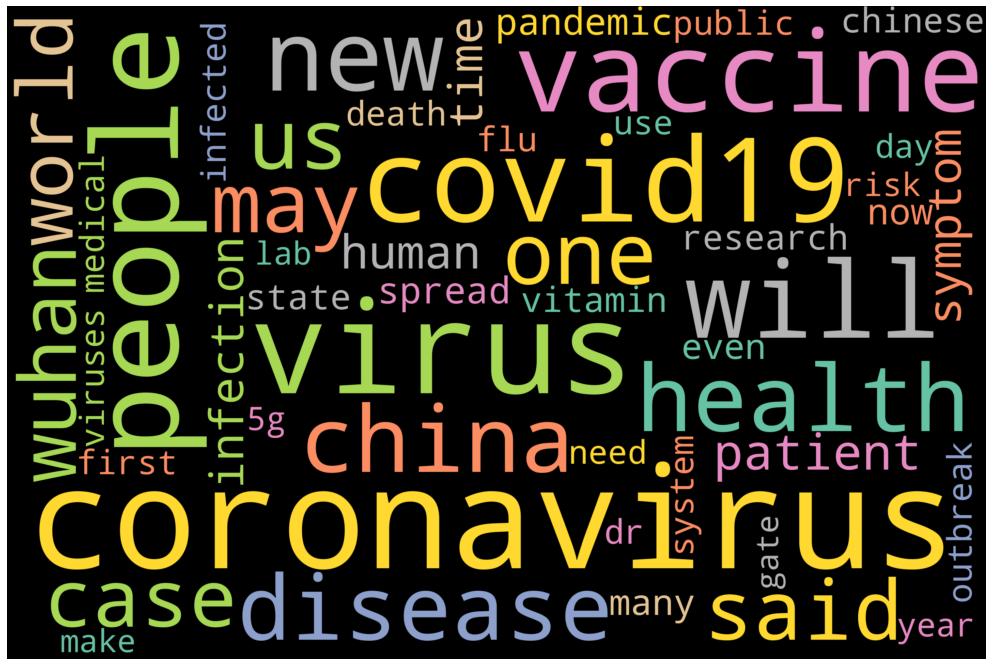

In [56]:
lst = []

for x in cnews['title_text']:
    lst.append(x)

lst = ' '.join(lst)

wordcloud = WordCloud(max_words= 50, width = 3000, height = 2000, background_color='black', colormap='Set2', collocations=False, stopwords=STOPWORDS).generate(lst)

plt.figure(figsize=(20, 12))
plt.imshow(wordcloud, interpolation='bilinear') 
plt.margins(x=0, y=0)
plt.axis("off")

Now it's time stem the words in order to save feature variables for the analysis. I always have used the Porter-stemmer for this task, but this time I'm going to try the Snowball-stemmer

In [19]:
snowst = SnowballStemmer(language='english') 

def stemmer(news):
    return [snowst.stem(word) for word in news.split()]

tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None, tokenizer=stemmer,use_idf=True, norm='l2', smooth_idf=True)

X = tfidf.fit_transform(cnews['title_text'])

y = cnews.label.values

In [20]:
X

<1159x25969 sparse matrix of type '<class 'numpy.float64'>'
	with 282630 stored elements in Compressed Sparse Row format>

In [21]:
y

array(['FAKE', 'FAKE', 'FAKE', ..., 'TRUE', 'TRUE', 'TRUE'], dtype=object)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

print(' X_train shape = ', X_train.shape, '\n', 'X_test shape = ', X_test.shape, '\n', 'y_train shape = ', y_train.shape, '\n', 'y_test shape = ', y_test.shape)

 X_train shape =  (811, 25969) 
 X_test shape =  (348, 25969) 
 y_train shape =  (811,) 
 y_test shape =  (348,)


As we see above, we have created a sparse matrix where every stimmed-tokenized word is feature variable(The shape is 1259 instances for 25969 columns that are the tokenized-stimmed words) which values are 0 if in the news doesn't appear the word and 1 if it is (Sparse matrix) for the X and the y that are the column with the label (True or Fake) that we are going to train our algortim. Then we have divided the X and the y in train set (811 instances) and test set (348 instances). Now let's going to create our models.

# MODEL SELECTION

Now we are going to create some models and see the scores produced after the training and will select one wichthe best performance gives us.

## LOGISTIC REGRESSION CROSS VALIDATION

In [23]:
lrcv = LogisticRegressionCV(cv=5, n_jobs=-1, scoring='accuracy', solver='lbfgs', penalty='l2', verbose=3)

lrcv.fit(X_train, y_train)

lrcv.score(X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   16.4s remaining:   24.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s finished


0.9511494252873564

## RANDOM FOREST CLASSIFIER

In [63]:
rf = RandomForestClassifier(bootstrap=True, verbose=3, n_jobs=-1, oob_score=True, criterion='entropy')

rf.fit(X_train, y_train)

rf.score(X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100building tree 7 of 100

building tree 8 of 100
building tree 9 of 100building tree 10 of 100

building tree 11 of 100building tree 12 of 100

building tree 13 of 100building tree 14 of 100

building tree 15 of 100
building tree 16 of 100
building tree 17 of 100building tree 18 of 100

building tree 19 of 100
building tree 20 of 100
building tree 21 of 100building tree 22 of 100building tree 23 of 100

building tree 24 of 100

building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100building tree 30 of 100

building tree 31 of 100
building tree 32 of 100
building tree 33 of 100building tree 34 of 100

building tree 35 of 100
building tree 36 of 100
bu

0.9281609195402298

## SUPPORT VECTOR CLASSIFIER

In [25]:
svc = SVC(kernel='rbf', verbose=3) # We are going to select a 'rbf' kernel, because if we use a 'linnear' kernel, would pratically the same algoritm that the first, logistic regression cross validation and therefore will gives us very similar score.

svc.fit(X_train, y_train)

svc.score(X_test, y_test)

[LibSVM]

0.9339080459770115